# Part 1: PriorityFloodFlowRouter & Lateral Channel Migration

This section of the notebook will walk you through an example of how LandLab components PriorityFloodFlowRouter and LateralEroder can be paired to investigate lateral channel migration in a landscape.

First and foremost, make sure to import the necessary packages. Note the annotations next to each of the packages  that explain what they will be used for!

In [1]:
import matplotlib.pyplot as plt                    # common package for plotting
import numpy as np                                 # common package for pretty much everything
from landlab import RasterModelGrid                # package needed to make the grid on which the LandLab components will run
from bmi_topography import Topography              # how we will get the DEM for the exercise
from landlab.io import read_esri_ascii             # will be used to read the DEM into a RasterModelGrid
from landlab import RasterModelGrid, imshow_grid, imshowhs_grid # how we will display the various outputs from the model
from landlab.components import PriorityFloodFlowRouter # LandLab component #1 that we will use; flow component
from landlab.components import FlowAccumulator, LateralEroder # LandLab component #2 that we will use; lateral erosion component

from matplotlib.colors import SymLogNorm           # will help us make the plot scales in a symmetrical log scale

## 1.1 Download the DEM from OpenTopography

Here we will use the bmi-topography package to import a DEM. This package and Python library will be used to access and import the NASA Shuttle Radar Topography Mission (SRTM) land elevation data, which we will use to run our model! For more information on this package and how to use it yourself follow these links: [bmi-topography repo](https://github.com/csdms/bmi-topography) and [notebook on bmi-topography](https://github.com/csdms/bmi-topography/blob/main/examples/topography.ipynb).

We will start by defining the variable topo, which will create an instance of topography, and we will define the following parameters:

1. the type of data we are requesting - in this case SRTMGL1 (SRTM Global Dataset 1, resolution ~30 m)
2. the geographic bounding (south, north, west, east) of the data
3. the file format we want - in this case we want as an ascii file
4. where to store the file

In [2]:
topo = Topography(
    dem_type="SRTMGL1",
    south=39.93,
    north=40.0,
    west=-105.33,
    east=-105.26,
    output_format="AAIGrid",
    cache_dir="DEMData//",
)

/opt/tljh/user/envs/ivy/lib/python3.13/site-packages/bmi_topography/api_key.py:48: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


Simply just creating the topo variable and creating an instance of topography does not download the data. We will also need to use `fetch` to download the data and `load` to commit the data to memory.

In [3]:
fname = topo.fetch()
print(fname)

/home/jupyter-mcarrington@utexas-7503b/ESPIn_Floods_2025-morggy-poo/notebooks/mcarr/DEMData/SRTMGL1_39.93_-105.33_40.0_-105.26.asc


In [4]:
dem = topo.load()
print(dem)

<xarray.DataArray 'SRTMGL1' (band: 1, y: 252, x: 252)> Size: 254kB
[63504 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 2kB 40.0 40.0 40.0 40.0 ... 39.93 39.93 39.93 39.93
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    -32768
    scale_factor:  1.0
    add_offset:    0.0
    units:         unknown


/opt/tljh/user/envs/ivy/lib/python3.13/site-packages/bmi_topography/topography.py:216: UserWarning: A CRS cannot be identified for these data. Grid units will be set to 'unknown'.
  warnings.warn(


We can now look at the downloaded data using `read_esri_ascii` and `imshow`!

/tmp/ipykernel_935457/1741896219.py:1: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation") # reading in the data, calling the grid object grid_geog and assigning topo to elev variable


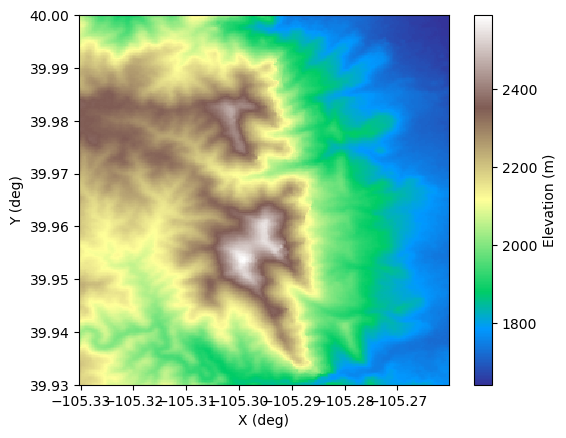

In [5]:
grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation") # reading in the data, calling the grid object grid_geog and assigning topo to elev variable

grid_geog.imshow( # visualizing the topo elevation using imshow!
    "topographic__elevation", 
    cmap="terrain",
    grid_units=("deg", "deg"),
    colorbar_label="Elevation (m)",
)

We're looking at a portion of the Flat Irons!

Looking at this visualization, you will notice that the X and Y axis are in degrees. This is telling us that the DEM is currently in a geographic coordinate system. We actually want the DEM, and soon to be raster model grid, to be in a projected coordinate system for what we want to do.

The code below will do all of this in one step, converting the DEM into a projected coordinate system *AND* reading it in as a LandLab grid object (`RasterModelGrid`) with spacing of 30 meters (the resolution of the STRM data). We will also define the topographic elevation to be recorded at the nodes.

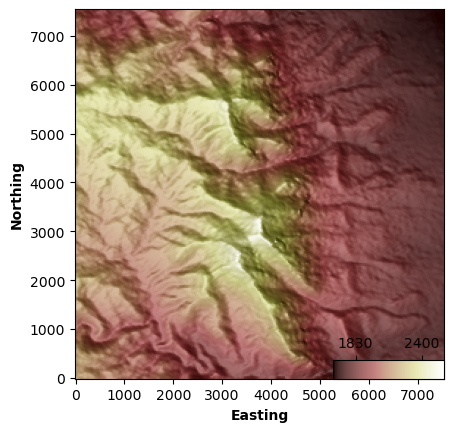

In [6]:
# make a new grid with RasterModelGrid, use the dimensions of grid_geog
grid = RasterModelGrid(grid_geog.shape, xy_spacing=30.0)
grid.at_node["topographic__elevation"] = grid_geog.at_node["topographic__elevation"]

imshowhs_grid(grid, "topographic__elevation"); # let's visualize this new LandLab grid object! 

As you can see from the imshow plot above, the DEM has now been projected and used to initialize a LandLab grid object.

## 1.2 Run the LandLab Components

With the LandLab grid now initialized, we can now begin to run the components: PriorityFloodFlowRouter and LateralEroder.

We will first start by instantiating the PriorityFloodFlowRouter, which fills/breaches depressions, accumulates flow, and calculates draiange area for a given LandLab grid object. More information about this component can be found here: [PriorityFloodFlowRouter Documentation](https://landlab.csdms.io/generated/api/landlab.components.priority_flood_flow_router.priority_flood_flow_router.html#landlab.components.priority_flood_flow_router.priority_flood_flow_router.PriorityFloodFlowRouter).

In [7]:
flow_metric = 'D8' # the flow algorithm to be used to calculate flow direction and flow accumulation
flow_acc_PF = PriorityFloodFlowRouter(grid, surface = 'topographic__elevation', flow_metric = flow_metric,
                                suppress_out = True, depression_handler = 'fill', accumulate_flow = True,
                                separate_hill_flow = True, accumulate_flow_hill = True) # instantiating the component here!

flow_acc_PF.run_one_step() # need to run the component one step in order to calculate the flow direction and accumulation

We can visualize the DEM aside the PriorityFloodFlowRouter drainage area calculation for our LandLab grid here using this incredible function writen by Dr. Susannah Morey!

In [8]:
def plotting(
    grid, 
    topo=True, # making a plot for elevation are plotting/visualization
    DA=True,  # making a plot for the calculated drianage area
    flow_metric="D8", # the flow routing algorithm again
):
    if topo: # a bunch of specifications to make the plots nice
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap="terrain",
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA: # some more specifications to make the drainage area plot nice
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap="terrain",
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric # adding flow metric label to the plot, could change this or add more plots for other algorithms!
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

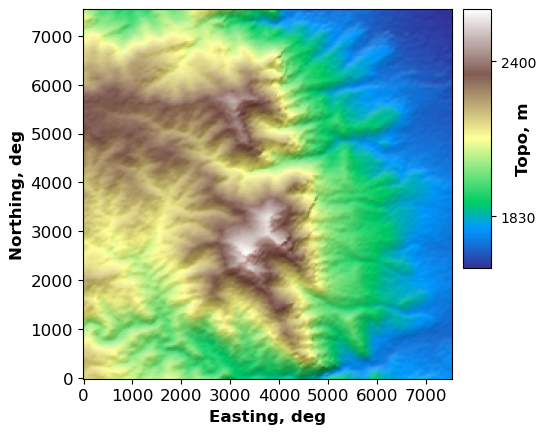

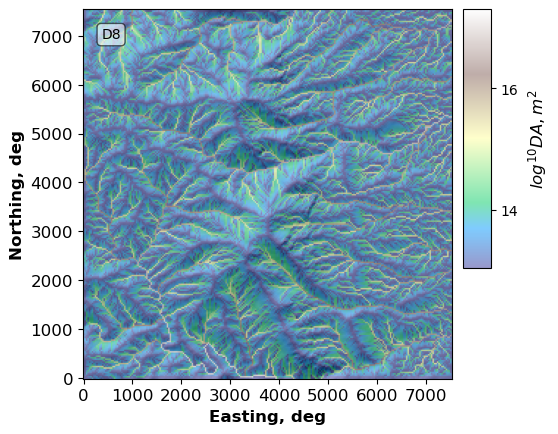

In [9]:
# Visualizing the elevation data and the drainage area calculations using the pretty code above :)
plotting(grid, DA=True)

We will next initialize the LateralEroder component which, when paired with the PriorityFloodFlowRouter, will model how fluvial erosion drives lateral channel migration.

Start first by intializing the grid nodes to record `volume__lateral_erosion`, which save arrays of lateral erosion in measurements of volume ($L^3$). Then run the component once in order to set us up for the next step o f the model.

In [10]:
# defining some necessary variables
U = 0.001 # uplift rate
dt = 100 # model time step

grid.add_zeros('volume__lateral_erosion', at = 'node') # initializing the lateral erosion volumes at the grid nodes

lateral = LateralEroder(grid, latero_mech = 'UC', Kv = 0.001, Kl_ratio = 1.5) # instantiating the LateralEroder
grid, dzlat = lateral.run_one_step(dt) # running component here, need both the grid object AND the change in lateral space variable

With both the PriorityFloodFlowRouter and the LateralEroder all instantiated and ran for one time step, we can now evolve the landscape!

The while loop below is designed to run the components until all channels in the landscape grid have some non-zero measure of lateral change from their initial condition. As a fun exercise, try writing this same code as a for loop (that is possible!).

In [11]:
while min(dzlat) == 0.0: # saying that this code will run until there is lateral change in every node possible
    oldlatvol = grid.at_node["volume__lateral_erosion"].copy() # make copies of the old lateral volume erosion arrays
    oldelev = grid.at_node["topographic__elevation"].copy() # copies the elevation arrays 
    flow_acc_PF.run_one_step() # runs the flow accumulator one more step as the landscape evolves (uplift, erosion, etc.)
    grid, dzlat = lateral.run_one_step(dt) # runs the lateral eroder for another dt-defined time step
    newlatvol = grid.at_node["volume__lateral_erosion"] # records new lateral volume erosion at the nodes
    newelev = grid.at_node["topographic__elevation"] # records new topo elevation at the nodes
    grid.at_node["topographic__elevation"][grid.core_nodes] += U * dt # uplift the surface at the core nodes!

## 1.3 Visualize the Results

Now, let's visualize some of the results from the model we ran above! We will use `plt.imshow` to show the various output variables. 

First looking at volume of laterally eroded material.

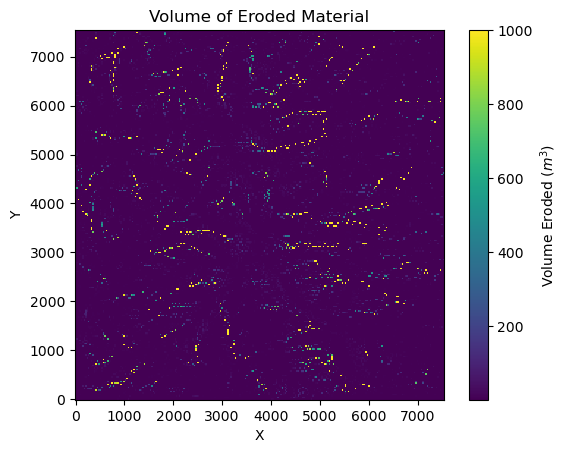

In [14]:
grid.imshow("volume__lateral_erosion", # calling on the values to be plotted
            plot_name="Volume of Eroded Material", # naming the plot
            var_name="Volume Eroded ($m^3$)", # naming the color bar
            norm = SymLogNorm(linthresh=1, vmin=grid.at_node['volume__lateral_erosion'].max(), vmax=grid.at_node['volume__lateral_erosion'].max()),
            vmin = 0.1,
            vmax = 1000, # setting the max of the color bar
            cmap = 'viridis', # colormap
           )

Let's look at sediment fluxes for the channels in this landscape.

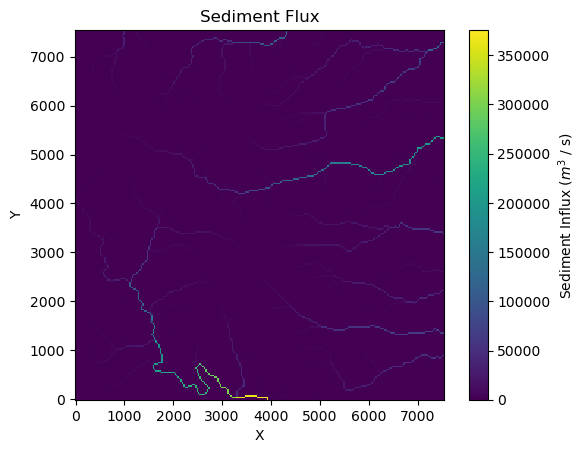

In [19]:
grid.imshow("sediment__influx", # defining the value of the node we want to look at
            plot_name="Sediment Flux", # naming the plot
            var_name="Sediment Influx ($m^3$ / s)",  # naming the color bar
            # vmin=0.1,
            # vmax=1000,
            norm='log',
            cmap = 'viridis', # another color map
           )

In this example, I only explore two possible outputs from the model. To see other examples of outputs that can be analyzed, use `output_var_names` as in the example below!

In [22]:
lateral.output_var_names

('lateral_erosion__depth_increment',
 'sediment__influx',
 'topographic__elevation',
 'volume__lateral_erosion')